# EEE 197z Project 1 - Zero Shot Object Detection
use SAM to perform zero-shot object detection using COCO 2017 val split. 

*Author: Sean Red Mendoza | 2020-01751 | scmendoza5@up.edu.ph*

## Tools/ References
- [SegmentAnything](https://github.com/facebookresearch/segment-anything)
- [OpenCLIP](https://github.com/mlfoundations/open_clip)
- [Coco 2017 Validation Dataset](https://cocodataset.org/#home)
- [roatienza/mlops](https://github.com/roatienza/mlops)
- [roatienza/Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments)
- [Google Cloud G2 GPU VM (2x Nvidia L4)](https://cloud.google.com/blog/products/compute/introducing-g2-vms-with-nvidia-l4-gpus)


## Goals
- Integrate SAM with OpenCLIP
- Compare CoCo Ground Truth vs Model Prediction vs Yolov8 Prediction
- Support random image pick from CoCo 2017 validation split OR manual image upload (link)
- Show Summary Statistics


## Approach
![Project Approach](../images/project_approach.png)

1. Automatically generate object masks for source image using [SAM AutomaticMaskGenerator](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb)
2. Filter masks using predicted_iou, stability score, and mask image area to garner better masking results
3. Crop source image based on generated masks
4. Run each crop under [OpenCLIP](https://github.com/mlfoundations/open_clip#pretrained-model-interface) (trained with [CoCo paper labels](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/))
5. Filter labels for most probable labels based on generated text probability
6. Evaluate mask bounding boxes using [mAPs score](https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb) and label accuracy (Top-1 vs Top-5) from ground truth labels
7. Tune SAM Model parameters to achieve better mAPs performance
8. Select appropriate OpenCLIP [pretrained model](https://github.com/mlfoundations/open_clip#pretrained-model-interface) to achieve better mAPs and label accuracy


## Usage 
1. Duplicate this repository on a working directory
```bash
git clone https://github.com/reddiedev/197z-zshot-objdetection
cd 197z-zshot-objdetection
```

2. Install the necessary packages
```bash
pip install -r requirements.txt
```
or alternatively, install them manually
```bash
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install matplotlib segment_anything opencv-contrib-python-headless
pip install open_clip_torch scikit-image validators

```

3. Run the jupyter notebook 
You may use the test images
```
../images/dog_car.jpg
https://djl.ai/examples/src/test/resources/dog_bike_car.jpg

```

4. To view complete logs and information, set `VERBOSE_LOGGING` to `TRUE`

## Notes
- It is recommended to use a CUDA-powered GPU with at least 40 GB VRAM, such as 2x L4s (current implementation), A100 40GB, or anything similar
    - if hardware resources are limited, it is recommended to use lower `points_per_batch` setting in SAM as well as to use a lighter pretrained model in OpenCLIP
- It is recommended to clone the repository for easier use, so you don't have to manually download any required files
- Due to hardware limitations, I am running the repo in a Google Cloud VM Instance. You may also consider leveraging [Credits](https://cloud.google.com/billing/docs/how-to/edu-grants) to make high-level computing accessible
- Ultimately, the performance of the system is limited because pretrained models are used instead of using the CoCo 2017 training dataset. This includes fine calibration of the SAM AutomaticMaskGenerator in comparison to the performance of Yolo v8. Similarly, the performance of OpenCLIP is bottlenecked by the quality of chosen labels and the pretrained model used.

In [19]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import torch
import torchvision
from skimage import io
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os

import open_clip
from PIL import Image
from pprint import pprint
import json
import shutil
import urllib

import cv2
import urllib.request
import validators
from pytriton.client import ModelClient

import csv


In [20]:
# toggle on verbose logging for some of the functions
VERBOSE_LOGGING = True
"""
bool: determine if the program outputs debug info
"""

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
print("[setup]: determining CUDA support...")
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

[setup]: determining CUDA support...
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


## Output Directory
Since the program requires using locally stored images, all assets and files will be saved in a dedicated /output directory

In [21]:
# clean output directory
def clean_output():
    """
    deletes the contents of the output directory, if it exists
    create output folder, if none exists
    """
    if not os.path.exists("../output"):
        os.mkdir(f"../output")
    shutil.rmtree("../output/")
    os.mkdir(f"../output/")
    
clean_output()

# SAM Tuning

Tuning the SegmentAnything model is very crucial as it specifies the quantity and quality of generated masks, which the other portions of the program rely on. Because the CoCo dataset is very varied, this makes calibration tuning as some images can only have 1 or 2 very distrinct subjects whereas others have many overlapping or relatively small objects in view.

I played with the different parameters with test images in order to perform as optimally as possible. My main problems was getting masks to stop overlapping (which causes redundancies and discrepancies in the results) of the same objects as well as to make masks cover entire objects. One of my other problems was also with layered masks with occlusion. One other problem was that masks sometimes cover more of the background of an object, instead of being finely bounded to the object itself.

Other considerations also included the amount of vram used, as well as the length of time for mask generation.


### pred_iou_thresh (Prediction IoU Threshold):
This parameter determines the threshold for the Intersection over Union (IoU) score between predicted bounding boxes and ground truth boxes. It controls how well the predicted boxes need to overlap with the ground truth boxes to be considered valid. Higher values result in stricter overlap requirements.

### box_nms_thresh (Box Non-Maximum Suppression Threshold):
This parameter controls the threshold for Non-Maximum Suppression (NMS) during post-processing. NMS is applied to remove redundant bounding boxes that cover the same object. A higher threshold allows more overlapping boxes to remain, while a lower threshold removes more duplicates.

### stability_score_thresh (Stability Score Threshold):
This parameter is specific to Segment Anything's automatic mask generator and determines the threshold for the stability score. The stability score measures the consistency of a pixel being assigned to a particular object across multiple frames or segments. Higher values indicate greater stability, and lower values allow more dynamic changes.

### min_mask_region_area (Minimum Mask Region Area):
The purpose of setting a minimum mask region area is to remove small, potentially noisy or irrelevant segments that may not be meaningful or useful for the specific segmentation task. By filtering out these smaller regions, you can focus on larger and more substantial objects in the scene, improving the overall quality and relevance of the generated masks.

In [22]:
sam_checkpoint = os.path.join("../checkpoints", "sam_vit_h_4b8939.pth")
print("[sam]: loading checkpoint file...")
# Download the file if it does not exist
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
if not os.path.isfile(sam_checkpoint):
    urllib.request.urlretrieve(url, sam_checkpoint)

print("[sam]: loading segment_anything model...")
model_type = "vit_h"
device_one = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device=device_one)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=128,
    pred_iou_thresh=0.8,
    box_nms_thresh=0, # prevent overlapping of masks
    stability_score_thresh = -0.4, # allow masks to cover "entire objects"
    crop_nms_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=4000,  # Requires open-cv to run post-processing,
)
print("[sam]: done loading segment_anything model!")

[sam]: loading checkpoint file...
[sam]: loading segment_anything model...
[sam]: done loading segment_anything model!


In [23]:

print("[0]: loading coco annotations and captions...")
dataDir = '../coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)

if not os.path.isfile(annFile):
    print("please download the coco val2017 instances dataset!")
    print("http://images.cocodataset.org/annotations/annotations_trainval2017.zip")
    quit()

# initialize COCO api for instance annotations + COCO ground truth api
cocoGt = COCO(annFile)
annFile = '{}/annotations/captions_{}.json'.format(dataDir, dataType)
coco_caps = COCO(annFile)
catIDs = cocoGt.getCatIds()
cats = cocoGt.loadCats(catIDs)
cocoCategories = [cat['name'] for cat in cats]
        
paperlabels_filename = "../labels/coco-labels-paper.txt"  
if not os.path.isfile(paperlabels_filename):
    print("please download the coco labels!")
    print("https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt")
    file_url = "https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt"
    urllib.request.urlretrieve(file_url, paperlabels_filename)
    
with open(paperlabels_filename, "r") as file:
    lines = file.readlines()  
cocopaper_labels = [line.strip() for line in lines]


[0]: loading coco annotations and captions...
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


# OpenCLIP Model Tuning

## Text Tokenizer 
Choosing the labels for the model is the most important since it determines the dataset from which labels are chosen. At first I thought about using ImageNet 1k labels ([Raw](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt) vs [Human-readable](https://github.com/anishathalye/imagenet-simple-labels)). I also even tried [Open Image Object Classes](https://ai.googleblog.com/2020/02/open-images-v6-now-featuring-localized.html) but these were too specific for the task at hand (e.g. specifying a dog breed instead of just *dog*). Ultimately, I decided on using the [CoCo paper labels](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/) as this is also the desired word list when comparing against the ground truth 

## Pretrained Model
Choosing the right model was easier than the text tokenizer. Looking at the model [performance](https://github.com/mlfoundations/open_clip#openclip), I chose **ViT-G/14 on LAION-2B** as it performed best in the CoCo images. Additionally, it can be run with an Nvidia L4 GPU, so hardware capacity was not a problem. It would be good moving forward if there existed an OpenCLIP pretrained model trained on CoCo images, as I believe that this is the major reason for the discrepancy in performance. 


In [24]:

print("[open-clip]: creating open clip model...")
modelType = 'ViT-B-32'
modelDataset = "laion2b_s34b_b79k"
model, _, preprocess = open_clip.create_model_and_transforms(
    modelType, pretrained=modelDataset)
tokenizer = open_clip.get_tokenizer(modelType)

device_two = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() >= 2:
    device_two = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device_two)

print("[open-clip]: done open clip model!")

[open-clip]: creating open clip model...
[open-clip]: done open clip model!


In [25]:
model_labels = []
"""
string[]: list of labels to be used by OpenClip Model
"""

print("[open-clip]: generating openclip labels dataset...")
# use coco paper categories as labels
model_labels.extend(cocopaper_labels)

# use SIMPLE IMAGENET LABELS

filename = "../labels/imagenet-simple-labels.json"
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Download the file if it does not exist
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    raw_imagenet_labels = eval(f.read())
imagenet_labels = []
for imagenet_label in raw_imagenet_labels:
    imagenet_labels.append(imagenet_label.lower().strip())
# if input_mode == "manual":
#     model_labels.extend(imagenet_labels)


# use Open Images Classes Dataset 
# from https://storage.googleapis.com/openimages/2017_11/classes_2017_11.tar.gz

filter_filename = "../labels/classes-bbox.txt"  
with open(filter_filename, "r") as file:
    lines = file.readlines()  
filter_classes = [line.strip() for line in lines]
labels_filename = '../labels/openimages-classes-raw.csv'
openimage_data = []
with open(labels_filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if (row[0] in filter_classes):
            openimage_data.append(row[1])

column_index = 1  
openimage_labels = [word.lower().strip() for word in openimage_data]
# if input_mode == "manual":
#     model_labels.extend(openimage_labels)

# PROCESS LABELS
# model_labels.append("unknown")
model_labels = list(set(model_labels)) # remove duplicates from wordlist
if VERBOSE_LOGGING:
    pprint(model_labels)
text = tokenizer(model_labels)
text = text.to(device_two)

print("[open-clip]: done generating openclip labels dataset!")


[open-clip]: generating openclip labels dataset...
['hat',
 'suitcase',
 'mirror',
 'bench',
 'desk',
 'person',
 'microwave',
 'train',
 'dining table',
 'pizza',
 'truck',
 'potted plant',
 'cake',
 'apple',
 'fork',
 'street sign',
 'hot dog',
 'donut',
 'toaster',
 'stop sign',
 'teddy bear',
 'parking meter',
 'cow',
 'wine glass',
 'tennis racket',
 'orange',
 'toothbrush',
 'vase',
 'remote',
 'sports ball',
 'bird',
 'motorcycle',
 'broccoli',
 'blender',
 'dog',
 'boat',
 'giraffe',
 'cell phone',
 'frisbee',
 'bus',
 'plate',
 'scissors',
 'carrot',
 'refrigerator',
 'zebra',
 'mouse',
 'sink',
 'baseball glove',
 'skateboard',
 'hair brush',
 'bowl',
 'keyboard',
 'oven',
 'elephant',
 'car',
 'toilet',
 'fire hydrant',
 'bottle',
 'door',
 'couch',
 'tie',
 'skis',
 'book',
 'kite',
 'cat',
 'tv',
 'clock',
 'surfboard',
 'bicycle',
 'shoe',
 'traffic light',
 'backpack',
 'chair',
 'umbrella',
 'baseball bat',
 'window',
 'sheep',
 'hair drier',
 'spoon',
 'banana',
 'lapt

## Images
This program supports manual entry of input image link/file path or random sampling from the CoCo 2017 Validation Dataset
*Please select your desired input method below:*

- [1] Enter Input Image Link/ File Path
- [2] Leave blank for Random CoCo Image from the 2017 Validation Split


In [26]:
user_input = "https://djl.ai/examples/src/test/resources/dog_bike_car.jpg"
"""
string: stores image file path or link from user input
"""

def get_valid_input():
    """ 
    gets a valid image source from user input
    
    - manual image link/ file path
    - leave blank for random 1 image
    """
    while True:
        user_input = input("Enter image link (leave blank for random image):")
        if user_input == "":
            return "random"
        elif validators.url(user_input):
            return "manual"
        else:
            print("File path entered, please ensure image exists at provided file path")
            

input_mode = get_valid_input()
"""
- manual: user provided image file path or link
- random: program will get random image from coco 2017 validation dataset
"""

if input_mode == "manual":
    print(f"You have selected MANUAL image analysis of {user_input}")
elif input_mode == "random":
    print(f"You have selected a RANDOM image analysis from the CoCo 2017 dataset")

You have selected a RANDOM image analysis from the CoCo 2017 dataset


In [27]:
image_category_ID = 0
image_ID = 0
image_area = 0
image_link = ""
image_ground_truth_labels = []

def get_random_coco_image(n):
    """
    gets random image/s from the coco 2017 validation dataset

    args:
        n (int): number of images to retrieve
        
    returns:
        imgID (int): coco image id
        catID (int): coco category ID (randomly generated)
        imgURL (string): link to the image
        imgArea (float): image pixel area
        ground_truth_labels (string[]): ground truth labels for image from coco captions

    """
    for i in range(n):
        # get random coco image
        catID = catIDs[np.random.randint(0, len(catIDs))]
        catImages = cocoGt.getImgIds(catIds=[catID])
        imgID = catImages[np.random.randint(0, len(catImages))]
        # build image meta data
        img = cocoGt.loadImgs(imgID)[0]
        imgArea = img['height']*img['width']
        imgURL = img['coco_url']
        # fetch ground truth labels from coco
        annIds = coco_caps.getAnnIds(imgIds=imgID)
        anns = coco_caps.loadAnns(annIds)
        ground_truth_labels = list(map(lambda x: x['caption'], anns))
        return imgID, catID, imgURL, imgArea, ground_truth_labels
    

if input_mode == "random":
    image_ID, image_category_ID, image_link, image_area, image_ground_truth_labels = get_random_coco_image(1)
elif input_mode == "manual":
    image_link = user_input


In [28]:
coco_results = []
label_results = []
top_one_score = 0
top_five_scores = []

In [29]:
def show_anns(anns):
    """ 
    writes annotations/masks on image in matplotlib figure
    
    args:
        anns (SAMMask[]): list of SAM Masks
    """
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
        
def shows_masks_with_labels(anns, labels, probs):
    """ 
    writes masks on image in matplotlib figure and annotates label with probability
    
    args:
        anns (SAMMask[]): list of SAM Masks,
        labels (string[]): labels for each mask,
        probs (float[0,1][]): probability for each label
    """
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    MINIMUM_MASK_PROB = 0.51
    for i in range(len(sorted_anns)):
        mask = sorted_anns[i]
        label = labels[i]
        prob = probs[i]
        if (prob >= MINIMUM_MASK_PROB):
            x, y, w, h = mask['bbox']
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
            ax.add_patch(rect)
            color = np.append(color, 0.5)
            ax.text(x, y, f"{label} {prob:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))


def generate_masks(image):
    """
    automatically generates masks for a given image using SAM AutomaticMaskGenerator
    
    args:
        image: image file
    
    returns: 
        list of masks
    """
    raw_masks = mask_generator.generate(image)
    for i in range(len(raw_masks)):
        mask = raw_masks[i]
        if VERBOSE_LOGGING:
            print(f"[mask-{i+1}]: predicted_iou: {mask['predicted_iou']:.2f}, stability score: {mask['stability_score']:.2f}")
    sorted_raw_masks = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    return sorted_raw_masks

def filter_masks(raw_masks, area):
    """
    removes undesired masks for better object detection performance
    
    args:
        raw_masks (SAMMask[]): list of SAM Masks,
        area (float): minimum image area (pixels) 
        
    returns:
        filtered_masks (SAMMask[]): filtered list of SAM Masks
    """
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    filtered_masks = []
    for i in range(length):
        mask = sorted_anns[i]
        if (mask['area'] < area):
            continue
        filtered_masks.append(mask)
    return filtered_masks


def save_raw_mask_images(image, raw_masks):
    """
    crops source image from generated raw masks and saves each as .jpg files
    
    args:
        image: image file,
        raw_masks (SAMMask[]): list of raw SAM Masks
    """
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/raw-mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1
        
def save_mask_images(image, filtered_masks):
    """
    crops source image from generated filered masks and saves each as .jpg files
    
    args:
        image: image file,
        filtered_masks (SAMMask[]): list of filtered SAM Masks
    """
    if len(filtered_masks) == 0:
        return
    length = len(filtered_masks)
    sorted_anns = sorted(filtered_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1

def generate_labels(anns):
    """
    generates labels for each mask using OpenClip 
    
    args:
        anns (SAMMask[]): list of masks
        
    returns:
        labels (string[]): labels for each mask,
        probs (float[0,1][]): probability for each label
    """
    if len(anns) == 0:
        return
    length = len(anns)
    labels = []
    probs =  []
    for i in range(length):
        mask = anns[i]
        im = Image.open(f"../output/mask-{i+1}.jpg").convert("RGB")
        img = preprocess(im).unsqueeze(0)
        img = img.to(device_two)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(img)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @
                          text_features.T).softmax(dim=-1)

        text_prob = np.max(text_probs.cpu().numpy())
        index = np.argmax(text_probs.cpu().numpy())
        
        # show most probable labels
        label = model_labels[index]
        sorted_probs = np.argsort(text_probs.cpu().numpy(), axis=None)
        top_sorted_probs = sorted_probs[:5]
        other_labels = []
        for j in range(5):
            test_label_index = top_sorted_probs[j]
            test_label = model_labels[test_label_index]
            other_labels.append(test_label)
        other_labels_text = " ".join(other_labels)
        
        # saves most probable masks for coco evaluation 
        TEXT_PROB_THRESHOLD = 0.8
        if input_mode == "random" and label in cocopaper_labels and text_prob >= TEXT_PROB_THRESHOLD:
            image_category = cocopaper_labels.index(label)
            result = {'image_id': image_ID, 'category_id': image_category+1,
                    "bbox": mask['bbox'], "score": mask['predicted_iou']}
            coco_results.append(result)

        labels.append(label)
        probs.append(text_prob)
        
        if VERBOSE_LOGGING:
            print(f"[{i+1}/{length}]:",  label, f"({text_prob*100:.2f}%)", other_labels_text)
    return labels, probs
        

def save_labels(anns, labels, probs):
    """
    saves and processes labels for accuracy analysis 
    
    args:
        anns (SAMMask[]): list of masks
        labels (string[]): labels for each mask,
        probs (float[0,1][]): probability for each label
        
    returns:
        Dict list: most probable labels for each mask
    """
    if len(anns) == 0:
        return
    length = len(anns)
    values = []
    for i in range(length):
        mask = anns[i]
        label = labels[i]
        text_prob = probs[i]
        values.append(
            {"label": label, "area": mask["area"], "prob": text_prob})
        
    # generate top 5 labels according to label_accuracy and mask_area
    sorted_values = sorted(values, key=lambda x: x['prob'], reverse=True)
    payload = sorted_values[:5]
    labels = list(map(lambda d: d['label'], payload))
    return labels

def isTopNAccurate(substrings, string):
    """
    determines if generated labels are in ground truth label
    
    args:
        substring(string[]): generated labels 
        string(string): ground truth labels string
        
    returns:
        results (bool[]): whether each generated label is correct or not
    """
    results = []
    for substring in substrings:
        if substring.lower().strip() in string.lower().strip():
            results.append(True)
        else:
            results.append(False)
    return results

In [30]:
url = "http://202.92.132.48:8000/"
def infer_model(url=url, image="../images/dog_car.jpg", model="Yolov8x"):
    """
    runs a given image under Yolov8 prediction and object identification
    """
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
                     
        fig.savefig(f"../output/yolo-masks-labels.jpg",
            bbox_inches='tight', pad_inches=0)
                

[mask-1]: predicted_iou: 1.00, stability score: 0.99
[mask-2]: predicted_iou: 0.99, stability score: 0.98
[mask-3]: predicted_iou: 0.98, stability score: 0.97
[mask-4]: predicted_iou: 0.97, stability score: 0.98
[mask-5]: predicted_iou: 0.96, stability score: 0.97
[mask-6]: predicted_iou: 1.03, stability score: 0.98
[mask-7]: predicted_iou: 1.01, stability score: 0.99
[mask-8]: predicted_iou: 1.00, stability score: 0.98
[mask-9]: predicted_iou: 0.99, stability score: 0.99
[mask-10]: predicted_iou: 0.98, stability score: 0.97
[mask-11]: predicted_iou: 0.98, stability score: 0.98
[mask-12]: predicted_iou: 0.97, stability score: 0.98
[mask-13]: predicted_iou: 0.96, stability score: 0.93
[mask-14]: predicted_iou: 0.96, stability score: 0.99
[mask-15]: predicted_iou: 0.95, stability score: 0.99
[mask-16]: predicted_iou: 0.95, stability score: 0.96
[mask-17]: predicted_iou: 0.95, stability score: 0.99
[mask-18]: predicted_iou: 0.95, stability score: 0.97
[mask-19]: predicted_iou: 0.94, stabi

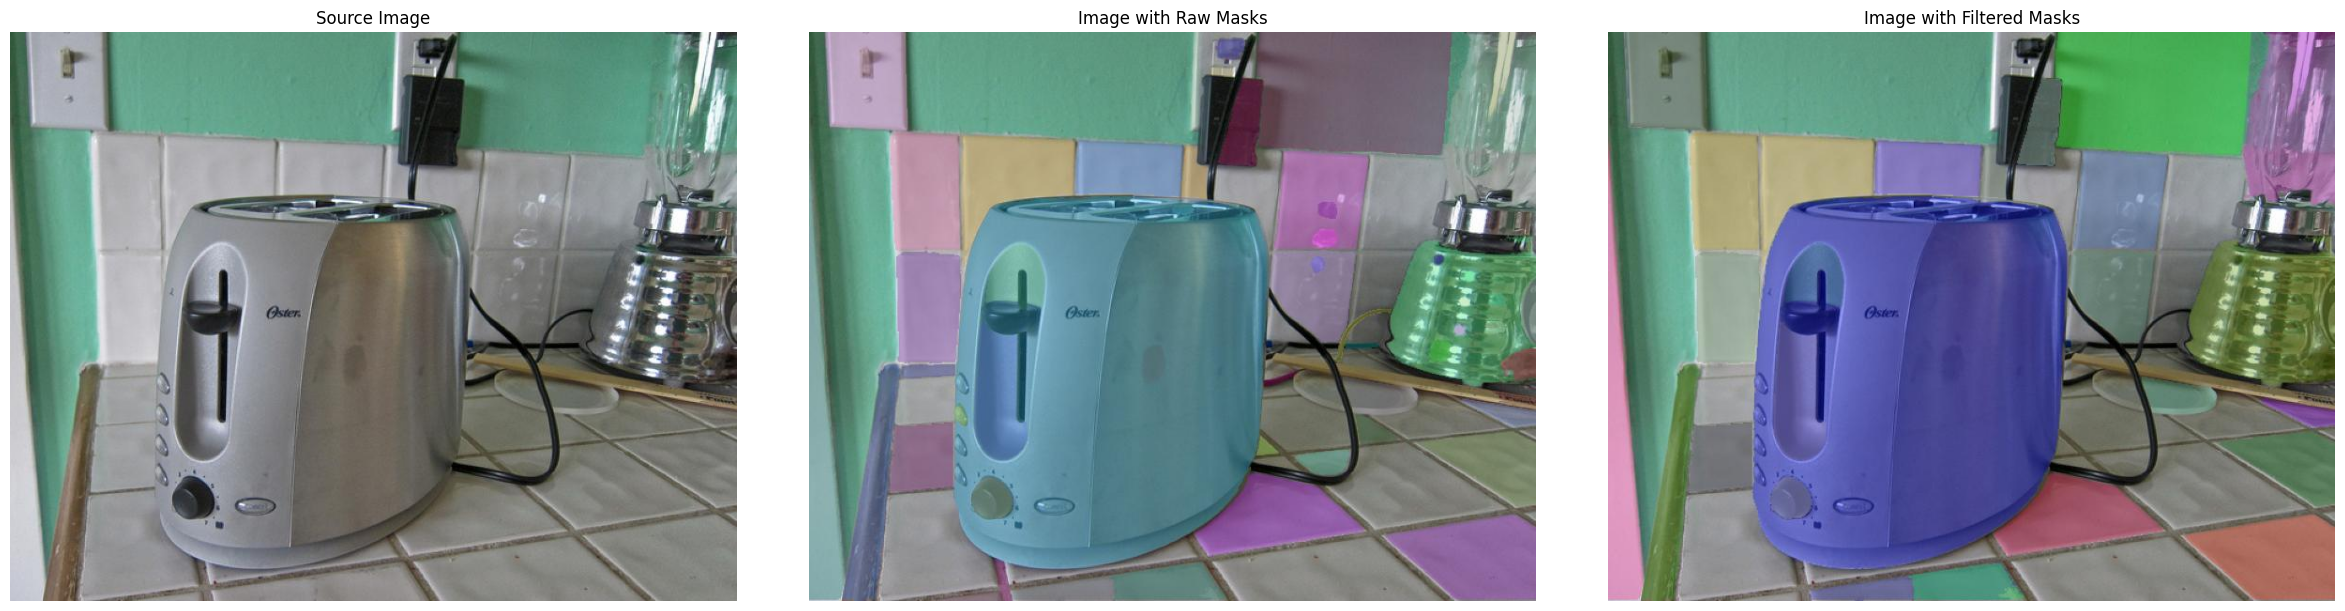

saving cropped mask image files...
generating labels...
[1/27]: toaster (91.42%) stop sign fire hydrant dining table baseball glove skateboard
[2/27]: bottle (19.98%) baseball glove parking meter hair brush hair drier blender
[3/27]: car (28.93%) street sign stop sign broccoli chair frisbee
[4/27]: door (22.21%) hat pizza dining table cake teddy bear
[5/27]: plate (16.20%) hair brush baseball glove backpack hair drier traffic light
[6/27]: book (36.47%) baseball glove pizza hair drier motorcycle parking meter
[7/27]: plate (27.21%) baseball glove broccoli hot dog pizza hair drier
[8/27]: mirror (22.07%) baseball glove teddy bear pizza sheep giraffe
[9/27]: laptop (12.24%) hair drier traffic light parking meter fire hydrant hair brush
[10/27]: bottle (60.29%) baseball glove pizza cake sports ball teddy bear
[11/27]: door (41.27%) baseball glove eye glasses dining table sports ball motorcycle
[12/27]: bottle (26.96%) baseball glove pizza sports ball cake eye glasses
[13/27]: door (42.45%

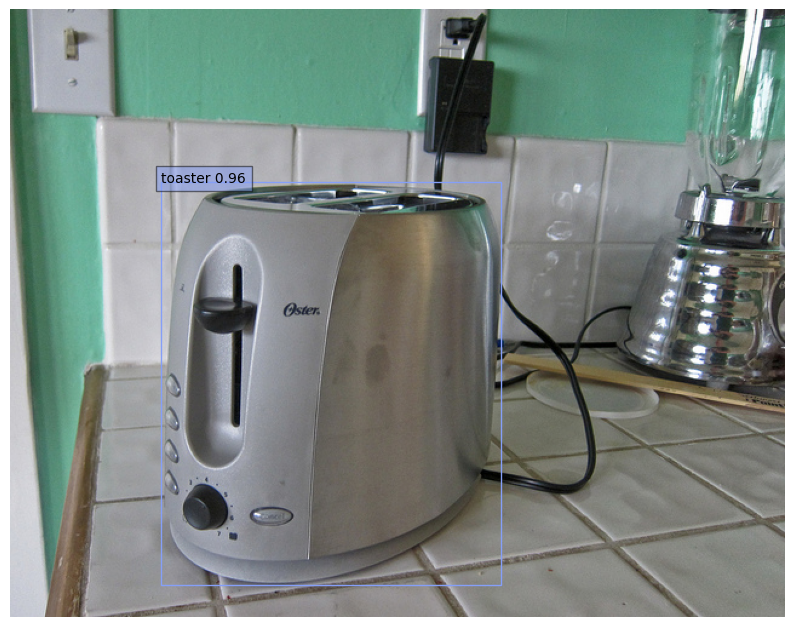

In [31]:
clean_output() # create output folder for this image

# get input image
image = io.imread(image_link)
height, width = image.shape[:2]
imageArea = height * width
maskArea = 0.0025 * imageArea

# save original image for future analysis
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.savefig(f"../output/source.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

# generate masks from SAM
raw_masks = generate_masks(image)    
if VERBOSE_LOGGING:
    print(f"generated {len(raw_masks)} masks...")
filtered_masks = filter_masks(raw_masks, maskArea)
if VERBOSE_LOGGING:
    print(f"masks filtered down to {len(filtered_masks)} masks...")
    
plt.figure(figsize=(10, 10))
plt.imshow(image)
if VERBOSE_LOGGING:
    print("applying raw masks on source image...")
show_anns(raw_masks)
plt.axis('off')
plt.savefig(f"../output/generated-raw-masks.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image)
if VERBOSE_LOGGING:
    print("applying filtered masks on source image...")
show_anns(filtered_masks)
plt.axis('off')
plt.savefig(f"../output/generated-filtered-masks.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

# shows original vs image with masks for visual comparison
source_image = io.imread(f"../output/source.jpg")
fig, axs = plt.subplots(1, 3,figsize=(30, 10))
axs[0].imshow(source_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Source Image")
masked_image = io.imread(f"../output/generated-raw-masks.jpg")
axs[1].imshow(masked_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image with Raw Masks")
masked_image = io.imread(f"../output/generated-filtered-masks.jpg")
axs[2].imshow(masked_image, cmap='gray')
axs[2].axis('off')
axs[2].set_title("Image with Filtered Masks")
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()

if VERBOSE_LOGGING:
    print("saving cropped mask image files...")
    save_raw_mask_images(image, raw_masks) # save raw mask image files
    
save_mask_images(image, filtered_masks) # save filtered masks image files

if VERBOSE_LOGGING:
    print(f"generating labels...")

# generate labels for each mask
generated_labels, generated_probs = generate_labels(filtered_masks)
plt.figure(figsize=(10, 10))
plt.imshow(image)
shows_masks_with_labels(filtered_masks, generated_labels, generated_probs)
plt.axis('off')
plt.savefig(f"../output/generated-masks-labels.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

# run yolo v8 prediction
infer_model(image=image_link)


In [32]:
clean_generated_labels = list(set(generated_labels)) # removes duplicates, if any

if input_mode == "random":
    # get ground truth captions from coco 2017 captions validation dataset
    if VERBOSE_LOGGING:
        print("currently evaluating CoCo w/ image ID:", image_ID, "...")
    annIds = coco_caps.getAnnIds(imgIds=image_ID)
    anns = coco_caps.loadAnns(annIds)
    ground_truth_labels = []
    for ann in anns:
        ground_truth_labels.append(ann['caption'])
    ground_truth_string = " ".join(ground_truth_labels)

    # filter most probable labels and determine accuracy
    sorted_labels = save_labels(filtered_masks, generated_labels, generated_probs)    
    top_one_score = sorted_labels[0] in ground_truth_string
    top_five_scores = isTopNAccurate(
        sorted_labels, ground_truth_string)
    

currently evaluating CoCo w/ image ID: 232348 ...


In [33]:
if (input_mode == "random"):    
    # evaluate mAPs performance
    json_object = json.dumps(coco_results, indent=4)
    with open("../output/results.json", "w") as outfile:
        outfile.write(json_object)
    cocoDt = cocoGt.loadRes("../output/results.json")
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.params.imgIds = [image_ID]
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

In [34]:
# compare label accuracy from ground truth, if any
print("GENERATED LABELS")
pprint(clean_generated_labels)
if (input_mode == "random"):
    print("GROUND TRUTH LABELS")
    pprint(ground_truth_labels)

if (input_mode == "random"):  
    print("-------------------------")
    print("Top-1 Label Accuracy SCORE:")
    print(f"{top_one_score*100:.2f}%")
    print("Top-5 Label Accuracy SCORE:")
    top_five_score = top_five_scores.count(True)/len(top_five_scores)
    print(f"{top_five_score*100:.2f}%")

GENERATED LABELS
['mirror',
 'bottle',
 'door',
 'toaster',
 'baseball bat',
 'laptop',
 'tv',
 'plate',
 'spoon',
 'window',
 'bird',
 'book',
 'knife',
 'skateboard',
 'car']
GROUND TRUTH LABELS
['Toaster and blender plugged in on a kitchen counter.',
 'A streamlined modern toaster on a kitchen counter top.',
 'A toaster sits on a kitchen shelf in front of a blender.',
 'A toaster and blender are sitting on a tile kitchen counter.',
 'A toaster and blender sitting on a counter top.']
-------------------------
Top-1 Label Accuracy SCORE:
100.00%
Top-5 Label Accuracy SCORE:
20.00%


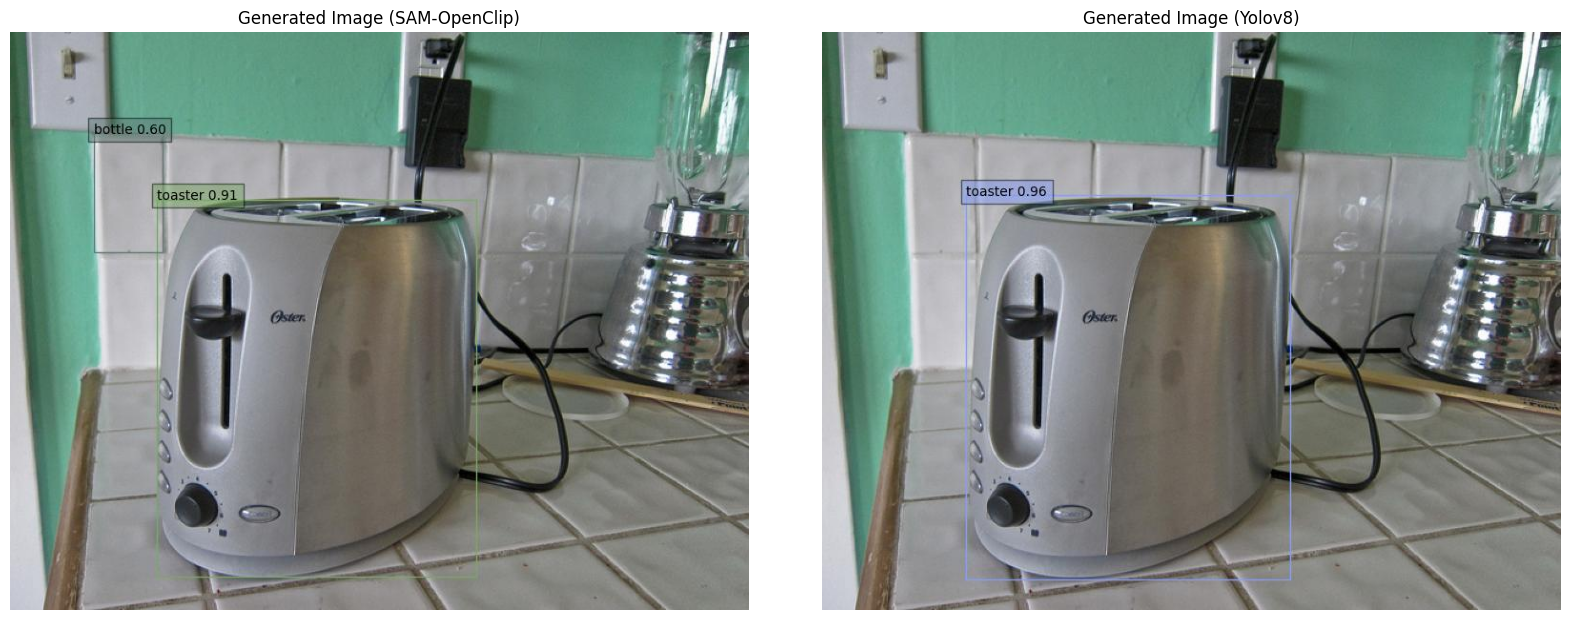

In [35]:
# compare own prediction vs yolov8 prediction
generated_image = io.imread(f"../output/generated-masks-labels.jpg")
fig, axs = plt.subplots(1, 2,figsize=(20, 10))
axs[0].imshow(generated_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Generated Image (SAM-OpenClip)")
yolo_image = io.imread(f"../output/yolo-masks-labels.jpg")
axs[1].imshow(yolo_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Generated Image (Yolov8)")
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()

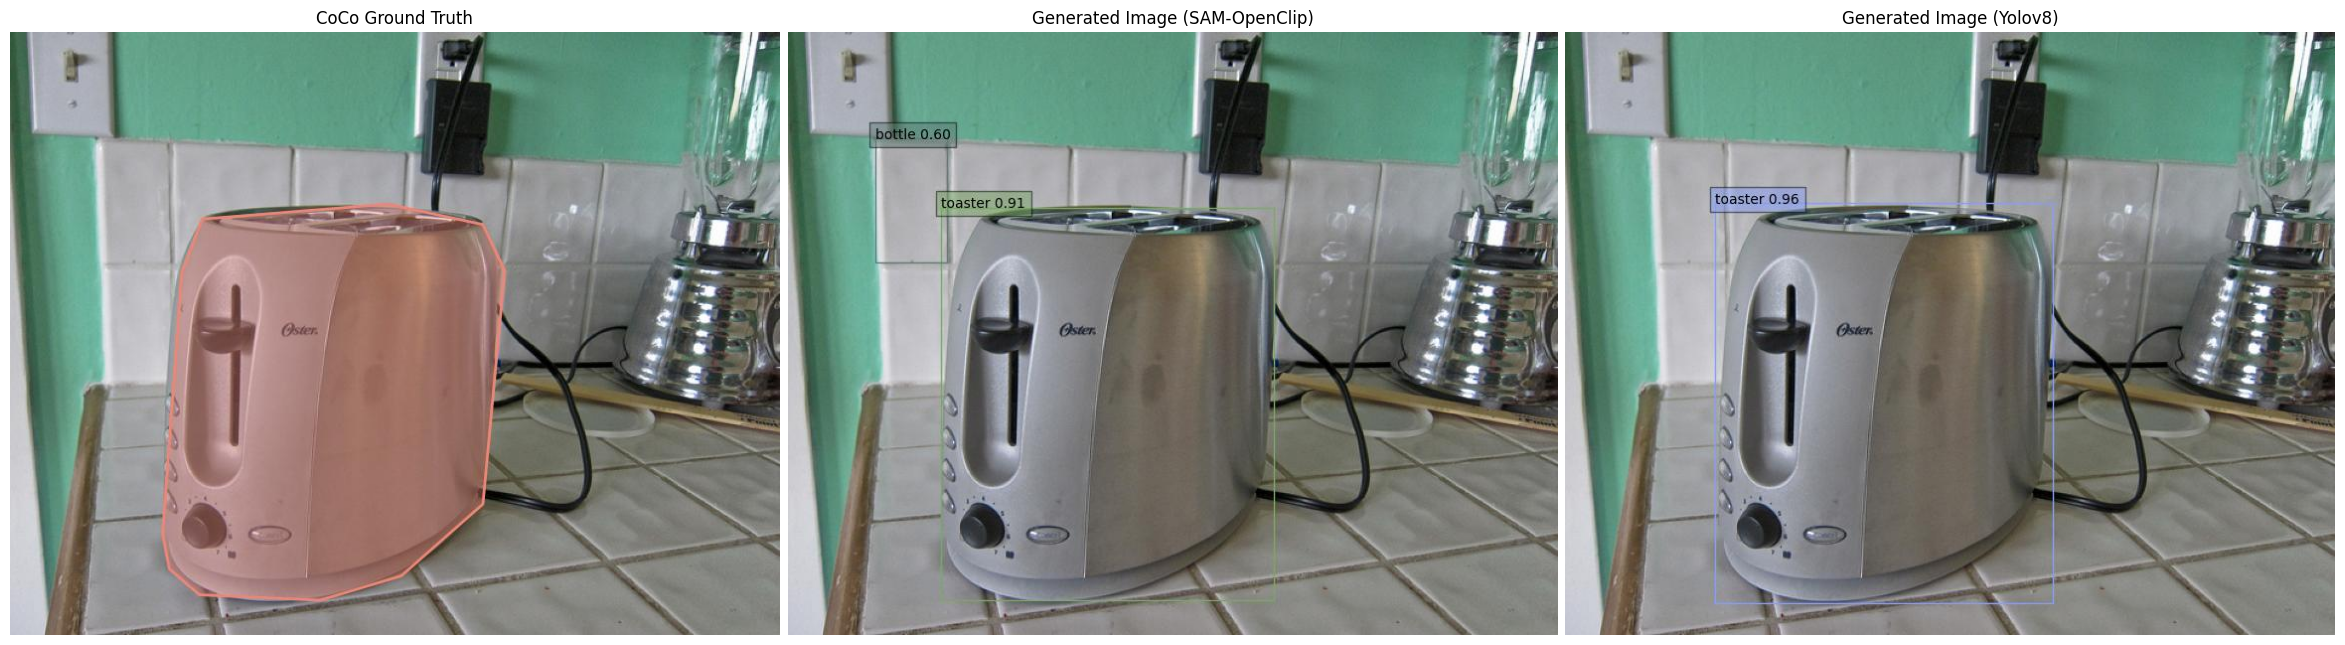

In [36]:
if input_mode == "random":
    # show coco ground truth, own prediction, and yolov8 prediction side by side
    plt.figure(figsize=(10, 10))
    plt.imshow(image); plt.axis('off')
    annIds = cocoGt.getAnnIds(imgIds=image_ID, catIds=catIDs, iscrowd=None)
    anns = cocoGt.loadAnns(annIds)
    cocoGt.showAnns(anns)
    plt.savefig(f"../output/coco-ground-truth.jpg",
            bbox_inches='tight', pad_inches=0)
    plt.close()
    
    coco_gt_image = io.imread(f"../output/coco-ground-truth.jpg")
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    axs[0].imshow(coco_gt_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("CoCo Ground Truth")
    axs[1].imshow(generated_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Generated Image (SAM-OpenClip)")
    axs[2].imshow(yolo_image, cmap='gray')
    axs[2].axis('off')
    axs[2].set_title("Generated Image (Yolov8)")
    plt.subplots_adjust(wspace=0.01)
    plt.show()
    plt.close()